# Proyek Klasifikasi Gambar: Car and Bike
- **Nama:** San Antonio Limbong
- **Email:** sanantoniolimbong@gmail.com
- **ID Dicoding:** san-limbong


## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# # Mengabaikan peringatan
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanantoniolimbong","key":"4b469d849264471d98855b53652d9c6e"}'}

In [3]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset
!unzip car-vs-bike-classification-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset
License(s): CC0-1.0
100% 103M/103M [00:00<00:00, 147MB/s] 
100% 103M/103M [00:00<00:00, 139MB/s]
Archive:  car-vs-bike-classification-dataset.zip
  inflating: Car-Bike-Dataset/Bike/Bike (1).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1).jpg  
  inflating: Car-Bike-Dataset/Bike/Bike (1).png  
  inflating: Car-Bike-Dataset/Bike/Bike (10).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (10).jpg  
  inflating: Car-Bike-Dataset/Bike/Bike (10).png  
  inflating: Car-Bike-Dataset/Bike/Bike (100).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (100).jpg  
  inflating: Car-Bike-Dataset/Bike/Bike (1000).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1001).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1002).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1003).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1004).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1005).jpeg  
  inflating: Car-Bike-Da

In [4]:
os.listdir('./')

['.config',
 'car-vs-bike-classification-dataset.zip',
 'Car-Bike-Dataset',
 'kaggle.json',
 'sample_data']

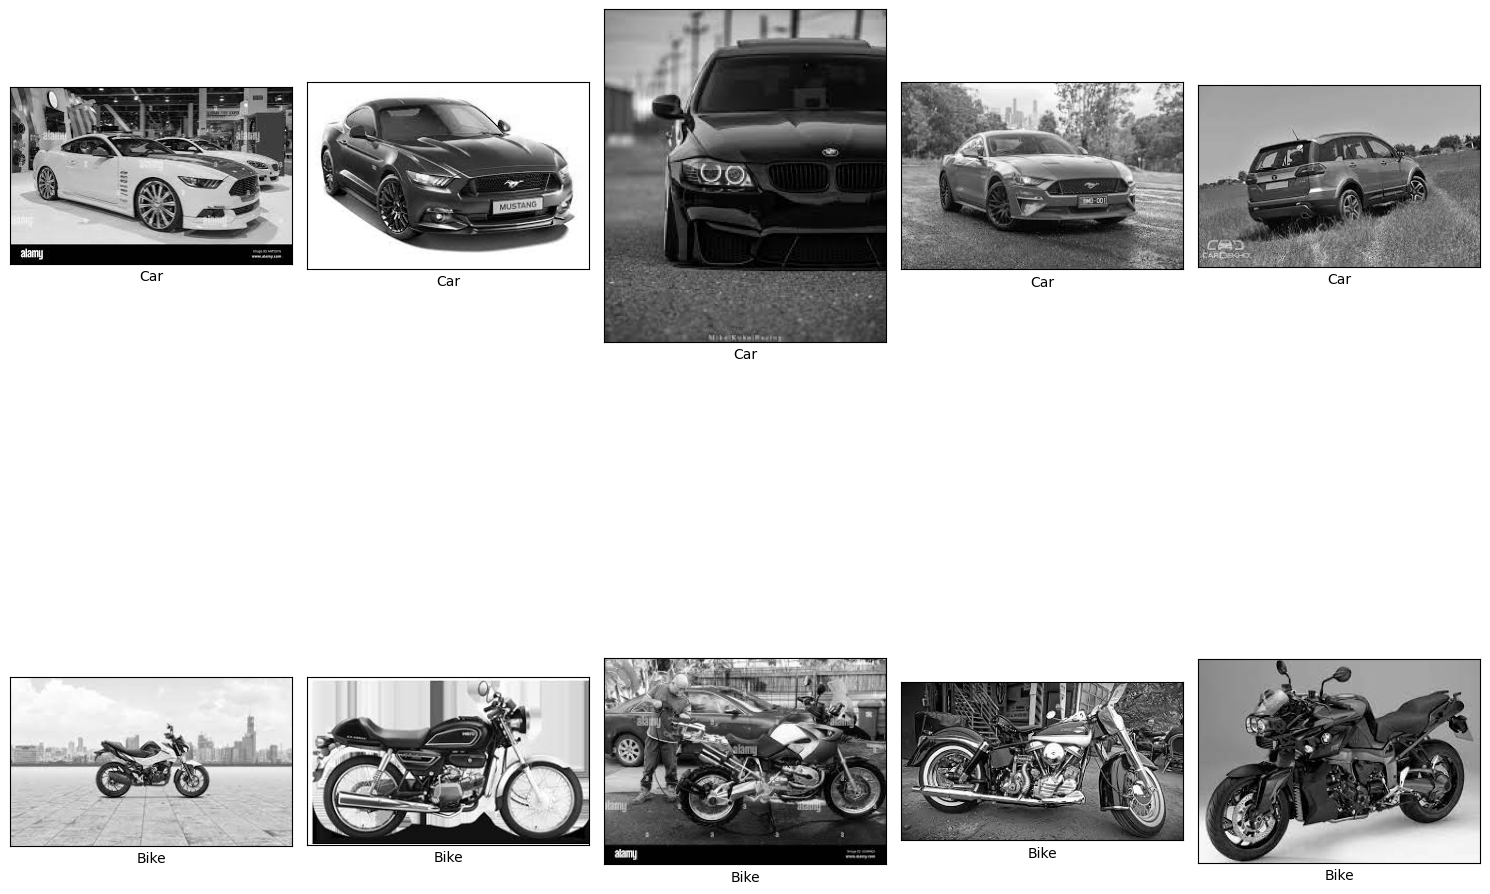

In [5]:
# Import the Image module from PIL
from PIL import Image
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "./"
path_sub = os.path.join(path, "Car-Bike-Dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "./Car-Bike-Dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

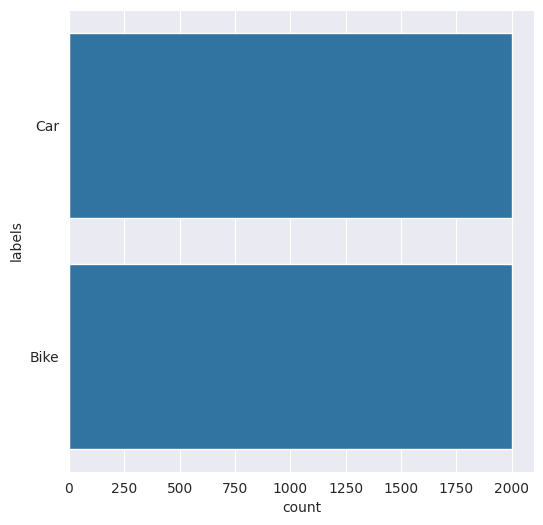

In [6]:
import seaborn as sns
# Define source path
lung_path = "./Car-Bike-Dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [7]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= './Car-Bike-Dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
Bike    2000
Car     2000
dtype: int64

In [8]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [9]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [10]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 3200
test size 800


In [11]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels
test   Bike       387
       Car        413
train  Bike      1613
       Car       1587
dtype: int64 


                                          path labels    set
3502  ./Car-Bike-Dataset/Bike/Bike (1208).jpeg   Bike   test
2135    ./Car-Bike-Dataset/Car/Car (1836).jpeg    Car  train
2912   ./Car-Bike-Dataset/Bike/Bike (533).jpeg   Bike  train
587     ./Car-Bike-Dataset/Car/Car (1488).jpeg    Car  train
250      ./Car-Bike-Dataset/Car/Car (441).jpeg    Car  train


In [12]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "./Car-Bike-Dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "./Dataset-Final/"

In [13]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [14]:
# Define training and test directories
TRAIN_DIR = "./Dataset-Final/train"
TEST_DIR = "./Dataset-Final/test"

train_Car = os.path.join(TRAIN_DIR + '/Car')
train_Bike = os.path.join(TRAIN_DIR + '/Bike')
test_Car = os.path.join(TEST_DIR + '/Car')
test_Bike = os.path.join(TEST_DIR + '/Bike')

print("Total number of Car images in training set: ",len(os.listdir(train_Car)))
print("Total number of Bike images in training set: ",len(os.listdir(train_Bike)))
print("Total number of Car images in test set: ",len(os.listdir(test_Car)))
print("Total number of Bike images in test set: ",len(os.listdir(test_Bike)))

Total number of Car images in training set:  1587
Total number of Bike images in training set:  1613
Total number of Car images in test set:  413
Total number of Bike images in test set:  387


In [15]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(100,100),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(100,100),
                                                   color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(100,100),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 2561 images belonging to 2 classes.
Found 639 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Modelling

In [16]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_7 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_7.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(100,100,1)))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_7.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_7.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# Flatten layer
model_7.add(Flatten())
# 1nd Dense Layer
model_7.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_7.add(Dropout(0.5))
# 2nd Dense Layer
model_7.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_7.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_7.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_7.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_7.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 100, 100, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        16416     
                                                                 
 batch_normalization_1 (Bat  (None, 50, 50, 32)        128       
 chNormalization)                                                
                                                        

In [17]:
# Menghentikan pelatihan setelah val_akurasi terpenuhi
class createEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('val_accuracy') >= 0.92:
            print('\n# This callback stop the training  at :', '\nEpoch :', epoch, ' Val_Accuracy :%2.2f%%' %(logs['val_accuracy']*100))
            self.model.stop_training = True

In [18]:
count_Car, count_Bike = len(os.listdir(train_Car)), len(os.listdir(train_Bike))
weight_0 = (1 / count_Car) * (count_Car + count_Bike) / 2.0
weight_1 = (1 / count_Bike) * (count_Bike + count_Car) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_1 = model_7.fit(train_generator,
                        epochs=10,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights,
                        callbacks = [createEarlyStopping()])

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.54 µs
Epoch 1/10
57/81 [====================>.........] - ETA: 19s - loss: 0.6747 - accuracy: 0.7368

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


81/81 [==============================] - 74s 832ms/step - loss: 0.5802 - accuracy: 0.7731 - val_loss: 0.6671 - val_accuracy: 0.5211
Epoch 2/10
81/81 [==============================] - 82s 1s/step - loss: 0.3069 - accuracy: 0.8832 - val_loss: 1.0938 - val_accuracy: 0.5039
Epoch 3/10
81/81 [==============================] - 71s 873ms/step - loss: 0.2442 - accuracy: 0.9110 - val_loss: 1.9931 - val_accuracy: 0.5039
Epoch 4/10
81/81 [==============================] - 69s 848ms/step - loss: 0.2068 - accuracy: 0.9207 - val_loss: 0.6337 - val_accuracy: 0.6761
Epoch 5/10
81/81 [==============================] - 72s 888ms/step - loss: 0.1620 - accuracy: 0.9352 - val_loss: 0.2898 - val_accuracy: 0.8779
Epoch 6/10
81/81 [==============================] - 73s 900ms/step - loss: 0.1118 - accuracy: 0.9594 - val_loss: 0.2649 - val_accuracy: 0.8983
Epoch 7/10
81/81 [==============================] - 69s 843ms/step - loss: 0.0935 - accuracy: 0.9652 - val_loss: 0.2067 - val_accuracy: 0.9171
Epoch 8/10
81

## Evaluasi dan Visualisasi

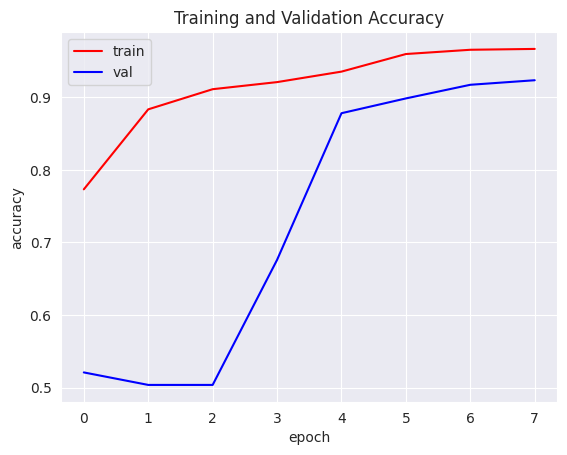

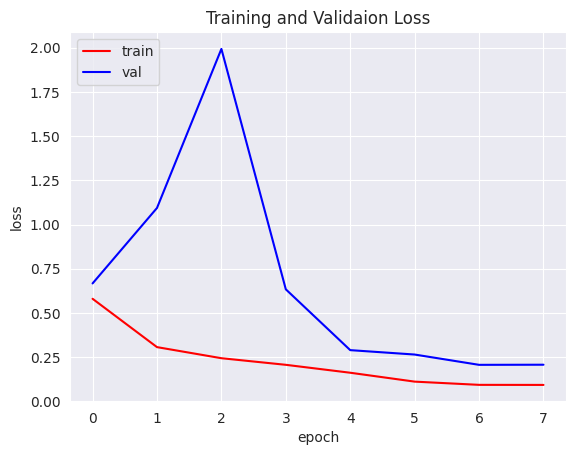

In [19]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

         Car     0.9588    0.9018    0.9294       387
        Bike     0.9128    0.9637    0.9376       413

    accuracy                         0.9337       800
   macro avg     0.9358    0.9327    0.9335       800
weighted avg     0.9351    0.9337    0.9336       800



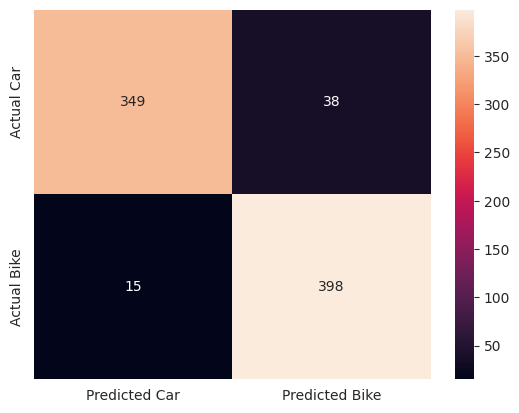

In [20]:
test_generator.reset()

preds_1 = model_7.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Car", "Actual Bike"],
columns=["Predicted Car", "Predicted Bike"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Car','Bike'], digits=4))

## Konversi Model

### TFJS

In [22]:
model_7.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
# Install tensorflowjs

!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1

In [24]:
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2024-07-17 06:21:48.341869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 06:21:48.372639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 06:21:48.372726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 06:21:50.193670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### TFLITE

In [25]:
export_dir = 'saved_model/'
tf.saved_model.save(model_7, export_dir)

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x79335ddc72e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x79335ddc72e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [26]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [27]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

2667992

## Requirements

In [28]:
!pip freeze > requirements.txt